In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
import keras
from tensorflow.compat.v1.keras import backend as K

In [2]:
def img2pd(path):
    res = {"filename": [],"label": []}
    baseDir = os.path.abspath('.')
    path = os.path.join(baseDir,'train')
    for file in os.listdir(path):
        _,label,_ = file.split('-')
        res['filename'].append(file)
        res["label"].append(label)
    df = pd.DataFrame.from_dict(res)
    return df

In [3]:
df = img2pd('train')

In [4]:
df.head()

,filename,label
0,train-cbb-0.jpg,cbb
1,train-cbb-1.jpg,cbb
2,train-cbb-10.jpg,cbb
3,train-cbb-100.jpg,cbb
4,train-cbb-101.jpg,cbb


In [5]:
df['label'].value_counts()

cmd        2658
cbsd       1443
cgm         773
cbb         466
healthy     316
Name: label, dtype: int64

<AxesSubplot:>

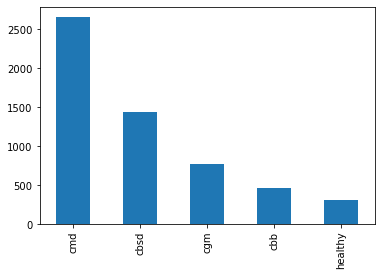

In [6]:
df['label'].value_counts().plot.bar()

In [7]:
train_img, valid_img = train_test_split(df, test_size = 0.15)

In [8]:
IMAGE_SIZE = 220
BATCH_SIZE = 12

In [9]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                               fill_mode = 'nearest', rotation_range = 15, width_shift_range = 0.2,
                               height_shift_range= 0.2, shear_range= 0.2, brightness_range= (.8,1.2),
                               zoom_range = 0.2)
train = train_gen.flow_from_dataframe(train_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                      target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                      batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 4807 validated image filenames belonging to 5 classes.


In [10]:
val_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                             fill_mode = 'nearest', rotation_range = 10, width_shift_range = 0.2,
                             height_shift_range= 0.2, shear_range= 0.15, brightness_range= (.5,1.2),
                             zoom_range = 0.2)
val = val_gen.flow_from_dataframe(valid_img, directory = 'train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 849 validated image filenames belonging to 5 classes.


(12, 220, 220, 3)


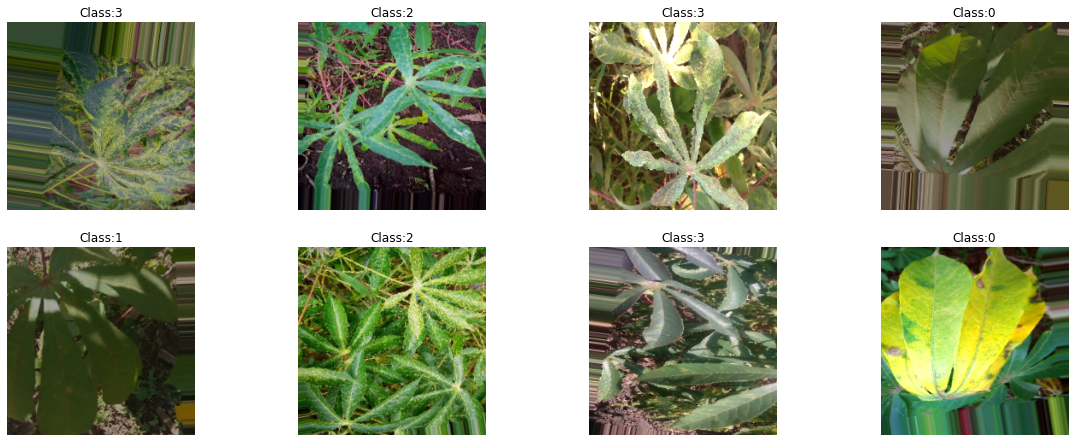

In [11]:
n_samples = 8

plt.figure(figsize=(20,20))
for x_gens, y_gens in train:
    print(x_gens.shape)
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        i += 1
        if i >= n_samples:
            break
    break

In [13]:
def create_model():
    
    model = Sequential()
    model.add(EfficientNetB3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, 
                             weights='imagenet', drop_connect_rate=0.5))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_________________________________________________________________


In [14]:
EPOCHS = 30
STEP_SIZE_TRAIN = train.n // train.batch_size
STEP_SIZE_TEST = val.n // val.batch_size

In [15]:
def model_fit():
    leaf_model = create_model()
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,label_smoothing=1e-3,name='categorical_crossentropy')
    
    leaf_model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss, metrics = ['categorical_accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
    checkpoint_cb = ModelCheckpoint("efficientNet_best.h5",save_best_only=True,monitor='val_loss',mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-7,mode='min',verbose=1)
    history = leaf_model.fit(train,validation_data=val,epochs=EPOCHS,batch_size=BATCH_SIZE,
                             steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_TEST,
                              callbacks=[checkpoint_cb, reduce_lr])
    
    leaf_model.save('efficientNet'+'.h5')  
    
    return history

In [16]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [17]:
with tf.device('/GPU:0'):
    results = model_fit()
print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/30
400/400 [==============================] - 257s 589ms/step - loss: 1.2087 - categorical_accuracy: 0.5612 - val_loss: 3.6903 - val_categorical_accuracy: 0.0536
Epoch 2/30
400/400 [==============================] - 227s 567ms/step - loss: 0.9276 - categorical_accuracy: 0.6757 - val_loss: 2.9942 - val_categorical_accuracy: 0.0536
Epoch 3/30
400/400 [==============================] - 227s 568ms/step - loss: 0.7947 - categorical_accuracy: 0.7278 - val_loss: 20.1023 - val_categorical_accuracy: 0.4726
Epoch 4/30
400/400 [==============================] - 228s 568ms/step - loss: 0.7424 - categorical_accuracy: 0.7479 - val_loss: 2.1635 - val_categorical_accuracy: 0.1274
Epoch 5/30
400/400 [==============================] - 229s 571ms/step - loss: 0.6844 - categorical_accuracy: 0.7628 - val_loss: 75.7066 - val_categorical_accuracy: 0.4738
Epoch 6/30
400/400 [==============================] - 231s 576ms/step - loss: 0.6494 - categorical_accuracy: 0.7870 - val_loss: 2.3392 - val_categor

In [20]:
def train_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()

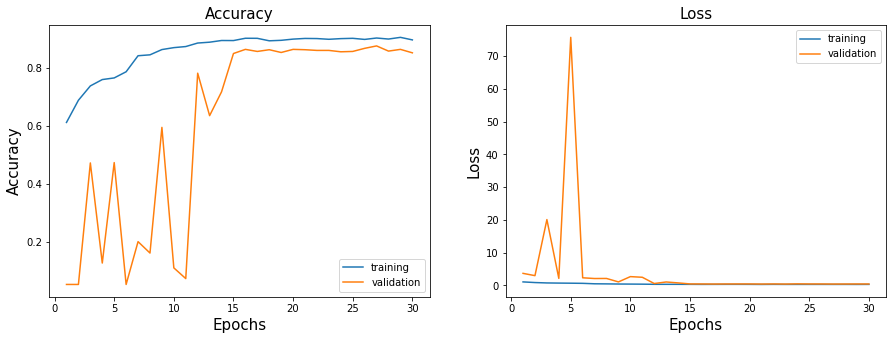

In [21]:
train_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)